In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [2]:
words = open('../names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [9]:
# building the vocab of words and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [10]:
# building the dataset
block_size = 3
def build_datatset(words):
    X,y = [] , []
    for w in words:
        context = [0] * block_size
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    y = torch.tensor(y)
    return X,y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,ytr = build_datatset(words[:n1])
Xval,yval = build_datatset(words[n1:n2])
Xte,yte = build_datatset(words[n2:])



In [11]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21],
        ...,
        [15, 12,  4],
        [12,  4,  1],
        [ 4,  1, 14]])

In [12]:
ytr

tensor([25, 21,  8,  ...,  1, 14,  0])

In [83]:
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed),generator=g)
w1 = torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3) / ((n_embed* block_size)**0.5)                 #0.2
b1 = torch.randn(n_hidden,generator=g) *0.01
w2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.1
b2 = torch.randn(vocab_size,generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

params = [C,w1,b1,w2,b2,bngain,bnbias]
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

12297


In [84]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    idx = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[idx],ytr[idx] # batch X , Y

    # forward pass
    emb = C[Xb]  # embed the chars ibn to vectors
    embcat = emb.view(emb.shape[0],-1)
    hpract = embcat @ w1 + b1 # hidden layer pre activation
    hpract = bngain * (hpract - hpract.mean(0,keepdim=True))/hpract.std(0,keepdim=True) + bnbias # batch normalization
    h = torch.tanh(hpract) # hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits,Yb) # loss function

    # backward pass
    for p in params:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in params:
        p.data += - lr * p.grad

    # track stats
    if i % 10000 ==0 :
        print(f"step {i} loss {loss.item():.4f}")

    lossi.append(loss.log10().item())



step 0 loss 3.9660
step 10000 loss 2.1967
step 20000 loss 2.2211
step 30000 loss 2.1936
step 40000 loss 2.3540
step 50000 loss 2.0469
step 60000 loss 2.0054
step 70000 loss 2.0642
step 80000 loss 2.2253
step 90000 loss 2.1094
step 100000 loss 1.9742
step 110000 loss 2.1036
step 120000 loss 2.2975
step 130000 loss 1.9901
step 140000 loss 2.4417
step 150000 loss 2.3255
step 160000 loss 2.0094
step 170000 loss 2.1755
step 180000 loss 1.9920
step 190000 loss 1.9064


tensor(-0.0076) tensor(1.0106)
tensor(0.0043) tensor(1.0159)


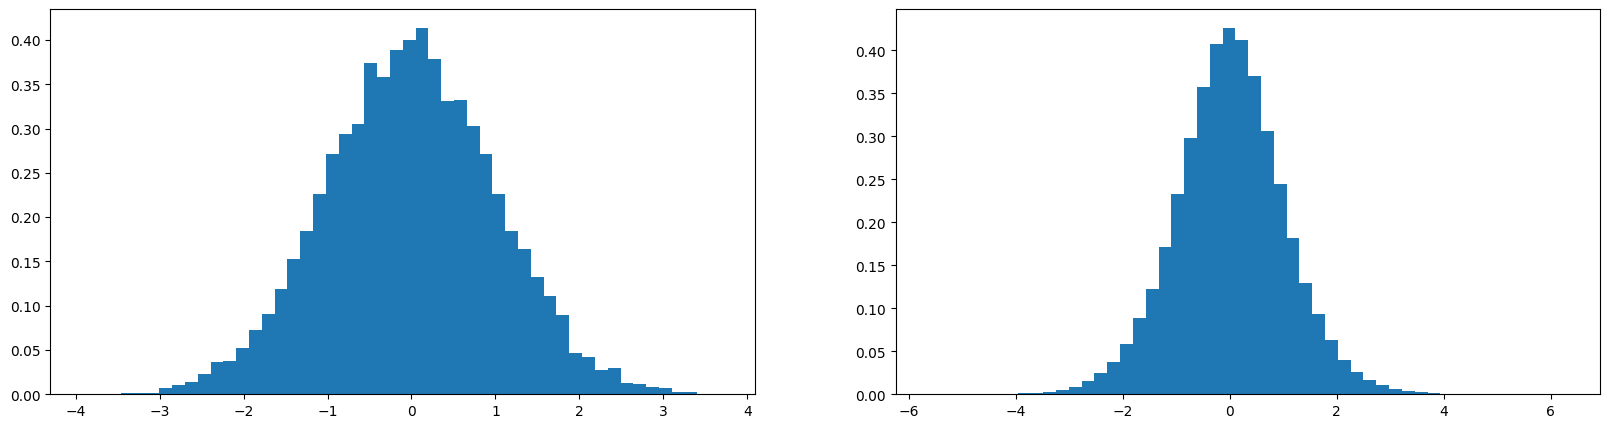

In [73]:
# the need of batch normalization explained
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);


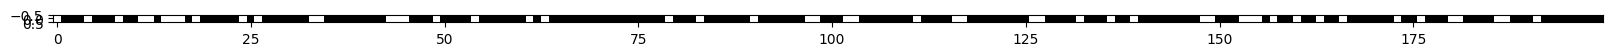

In [87]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest') # white is flat region and black is steep region of tanh function so black is good white is bad and if a column is completely white then basically that neuron is a dead neuron

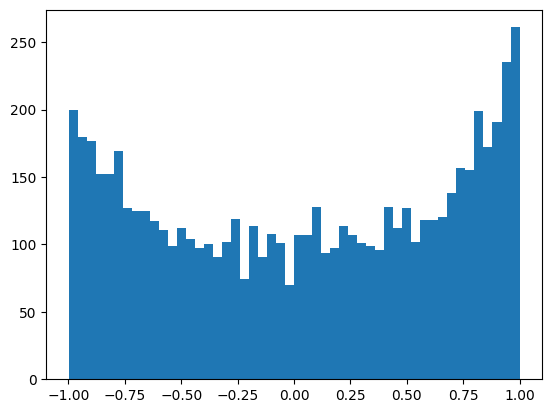

In [66]:
plt.hist(h.view(-1).tolist(),50);

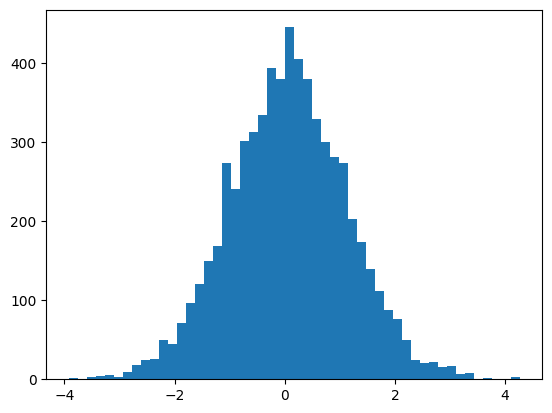

In [67]:
plt.hist(hpract.view(-1).tolist(),50);

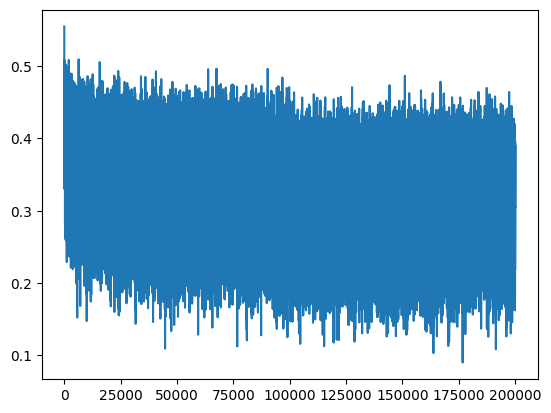

In [69]:
plt.plot(lossi)

In [85]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, ytr),
        'val': (Xval, yval),
        'test': (Xte, yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpract = embcat @ w1 + b1
    hpract = bngain * (hpract - hpract.mean(0,keepdim=True))/hpract.std(0,keepdim=True) + bnbias # batch normalization
    h = torch.tanh(hpract)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val')

train 2.069027900695801
val 2.107956647872925


In [86]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join([itos[i] for i in out]))

chlbbaldgllusnficzopxhncsolivitta.
chlkahkz.
ksanvstevorbexttschimtts.
khlissanvugbr.
qedvadklivizhssdel.
tkavifnyzaqlsnifwnndelvorhllswinsluvbraysl.
priwnnlanshlf.
quindss.
mckerr.
firmyggbikshbwrnbslarsnlucsthllscyprrmenrhsseengxmarquindstavjusdr.
jhskfngbitja.
khlivaddh.
chlesgfyillwvebhkifphdendstmasgabrxxmikstsncroskalcanhrcfobciassmasslaqwundch.
khlistaffiyasstissshdughn.
lucghncarlevonaj.
khnunsavighlisbryzdenlkahmi.
shfahnnasaddvikhtsghnn.
sklvagowrylmichnrvannahrydaqusnlcaosslnvserphtchfitiffrithtd.
chymarziahsrztvijusston.
cnichlkvizjahsr.
